In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [3]:
data, coordinates, pop_idx = cai()

<AxesSubplot:>

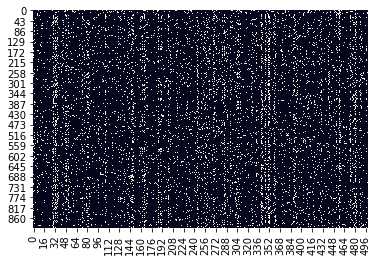

In [4]:
sns.heatmap(data[:,:500], cbar=False)

In [7]:
from tqdm.notebook import tqdm

n_epochs = 3000
N_H = 10
N_V = 900


rtrbm = RTRBM(data, N_H=10, device='cpu')

W = torch.zeros(N_H, N_V)
W_acc = torch.zeros(N_H, N_H)
dW_mean = torch.zeros(n_epochs)
dW_acc_mean = torch.zeros(n_epochs)
dW_std = torch.zeros(n_epochs)
dW_acc_std = torch.zeros(n_epochs)
v_contribution_r = torch.zeros(n_epochs, N_H)
h_contribution_r = torch.zeros(n_epochs, N_H)
v_contribution_p = torch.zeros(n_epochs, N_H)
h_contribution_p = torch.zeros(n_epochs, N_H)
bias = torch.zeros(n_epochs, N_H)

dW = torch.zeros(n_epochs, N_H, N_V)
dW_acc = torch.zeros(n_epochs, N_H, N_H)
db_H = torch.zeros(n_epochs, N_H)
db_V = torch.zeros(n_epochs, N_V)
db_init = torch.zeros(n_epochs, N_H)

errors = []

for epoch in tqdm(range(n_epochs)):
    
    rtrbm.learn(n_epochs=1, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0, disable_tqdm=True)
    
    dW[epoch :, :], dW_acc[epoch, :, :], db_H[epoch, :], db_V[epoch, :], db_init[epoch, :] = rtrbm.dparams
        

    rt = torch.zeros(rtrbm.N_H, rtrbm.T, dtype=torch.float)
    rt[:, 0] = torch.sigmoid(torch.matmul(rtrbm.W, rtrbm.V[:, 0]) + rtrbm.b_init)
    v_contribution_r += torch.mean(torch.matmul(rtrbm.W, rtrbm.V[:, 0]))
    bias[epoch, :] = rtrbm.b_init
    for t in range(1, rtrbm.T):
        rt[:, t] = torch.sigmoid(torch.matmul(rtrbm.W, rtrbm.V[:, t]) + rtrbm.b_H + torch.matmul(rtrbm.W_acc, rt[:, t - 1]))
        v_contribution_r[epoch, :] += torch.matmul(rtrbm.W, rtrbm.V[:, t])
        h_contribution_r[epoch, :] += torch.matmul(rtrbm.W_acc, rt[:, t - 1])
        bias[epoch, :] += torch.squeeze(rtrbm.b_H)
        
    errors += rtrbm.errors

    
    W = rtrbm.W
    W_acc = rtrbm.W_acc 
    

  0%|          | 0/3000 [00:00<?, ?it/s]

### Absolute contributions

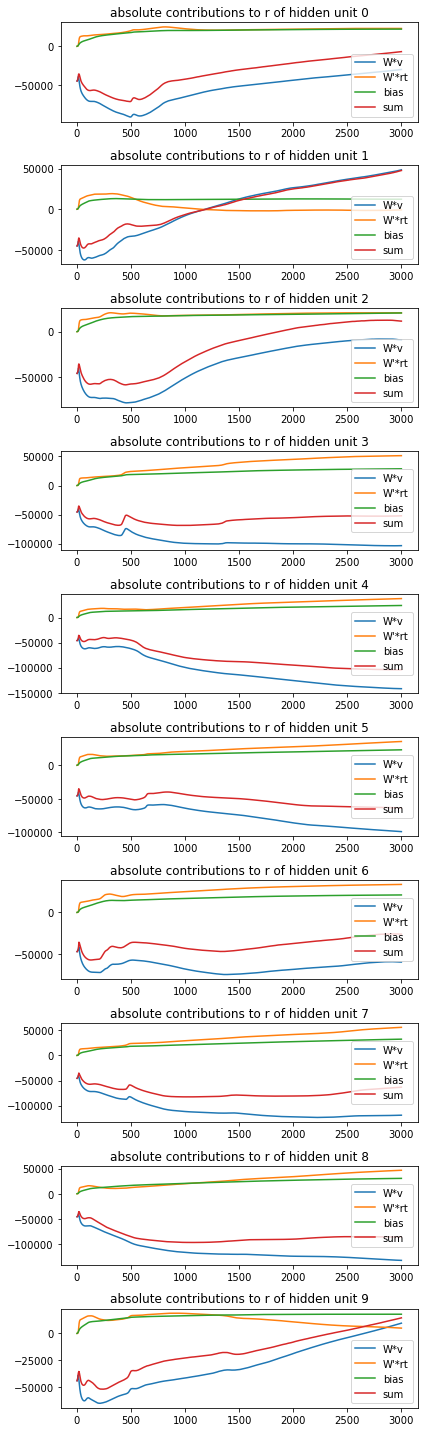

In [8]:
fig, axes = plt.subplots(10, 1, figsize=(6, 20))
epochs = torch.arange(n_epochs)
for i, ax in enumerate(axes):
    ax.plot(epochs, v_contribution_r[:, i])
    ax.plot(epochs, h_contribution_r[:, i])
    ax.plot(epochs, bias[:, i])
    ax.plot(epochs, (v_contribution_r[:, i] + h_contribution_r[:, i]))
    ax.set_title('absolute contributions to r of hidden unit ' + str(i))
    ax.legend(['W*v', 'W\'*rt', 'bias', 'sum'])
plt.tight_layout()

### Relative contributions

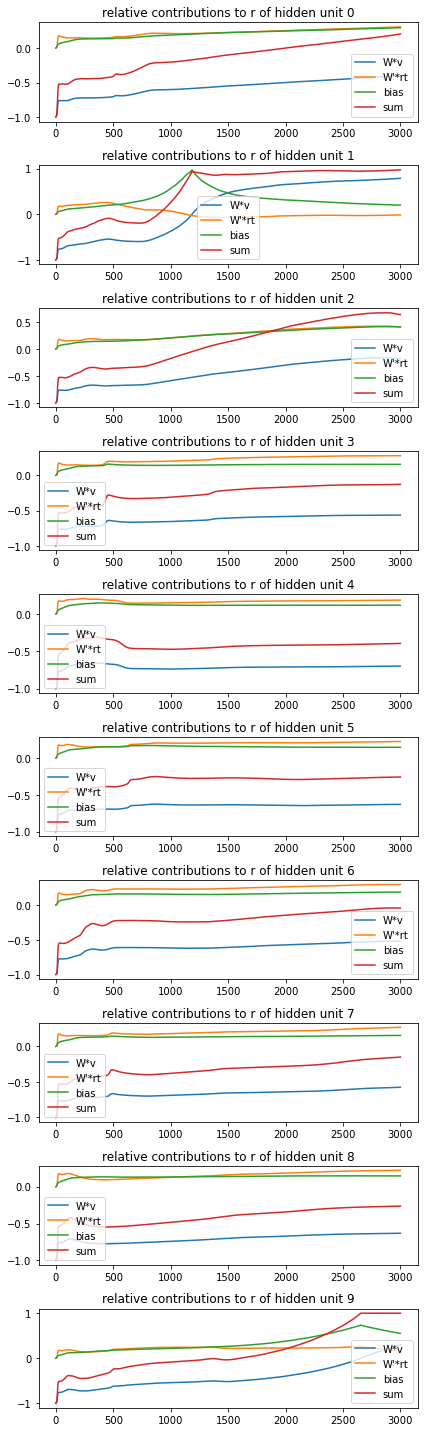

In [11]:
fig, axes = plt.subplots(10, 1, figsize=(6, 20))
epochs = torch.arange(n_epochs)
for i, ax in enumerate(axes):
    tot = torch.abs(v_contribution_r[:, i]) + torch.abs(h_contribution_r[:, i]) + torch.abs(bias[:, i])
    ax.plot(epochs, v_contribution_r[:, i] / tot)
    ax.plot(epochs, h_contribution_r[:, i] / tot)
    ax.plot(epochs, bias[:, i] / tot)
    ax.plot(epochs, (v_contribution_r[:, i] + h_contribution_r[:, i] + bias[:, i]) / tot)
    ax.set_title('relative contributions to r of hidden unit ' + str(i))
    ax.legend(['W*v', 'W\'*rt', 'bias', 'sum'])
    
plt.tight_layout()

### plotting the means of gradient updates

Text(0.5, 1.0, '$db_{init}$')

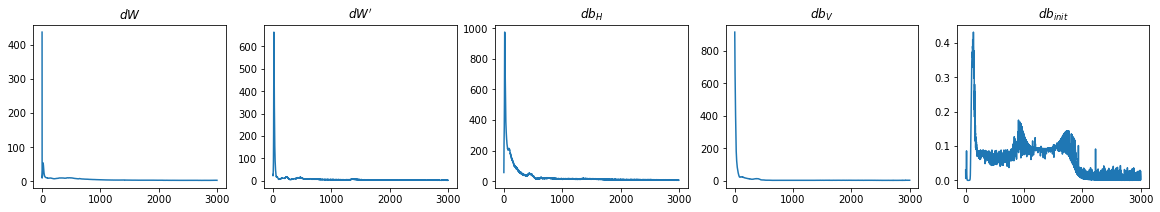

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
ax[0].plot(torch.mean(torch.abs(dW), (1, 2)))
ax[0].set_title('$dW$')
ax[1].plot(torch.mean(torch.abs(dW_acc), (1, 2)))
ax[1].set_title('$dW\'$')
ax[2].plot(torch.mean(torch.abs(db_H), 1))
ax[2].set_title('$db_H$')
ax[3].plot(torch.mean(torch.abs(db_V), 1))
ax[3].set_title('$db_V$')
ax[4].plot(torch.mean(torch.abs(db_init), 1))
ax[4].set_title('$db_{init}$')

In [13]:
rtrbm.errors

tensor([[0.1080]])

### Plotting the standard deviation of the gradient updates

Text(0.5, 1.0, '$db_{init}$')

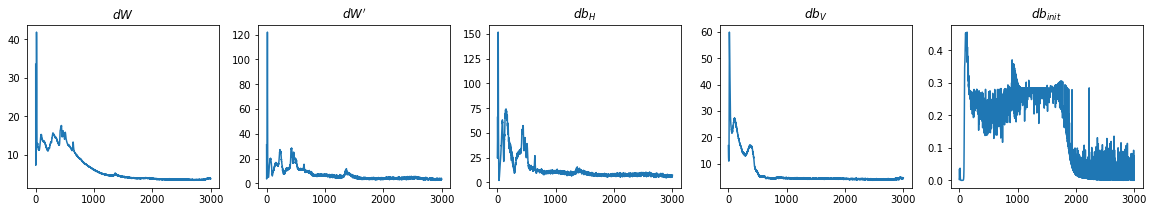

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
ax[0].plot(torch.std(dW, (1, 2)))
ax[0].set_title('$dW$')
ax[1].plot(torch.std(dW_acc, (1, 2)))
ax[1].set_title('$dW\'$')
ax[2].plot(torch.std(db_H, 1))
ax[2].set_title('$db_H$')
ax[3].plot(torch.std(db_V, 1))
ax[3].set_title('$db_V$')
ax[4].plot(torch.std(db_init, 1))
ax[4].set_title('$db_{init}$')